# Credit-Card-Fraud-Detection using Unsupervised Autoencoders

# Aims

In [ ]:
                       
Our project aim to train an Autoencoder Neural Network to detect and predict Anomaly in credit card transaction


# Libraries Importation 

In [6]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


# Data Importation

In [7]:

dataset = pd.read_csv(r'C:\Users\Ajay\Desktop\NoteMachine\creditcard.csv')

# Data Exploration 

In [7]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:

dataset.shape

(284807, 31)

In [6]:
#How many transaction are valid?
dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [3]:
frauds = dataset[dataset.Class == 1]
normal = dataset[dataset.Class == 0]

In [29]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
LABELS = ["Valid", "Fraud"]

Text(0, 0.5, 'Frequency')

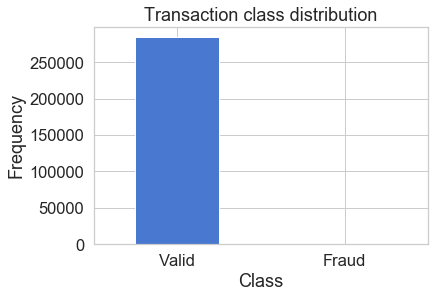

In [10]:

count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

We have unbalance dataset.

# To view the anomaly from the dataset 

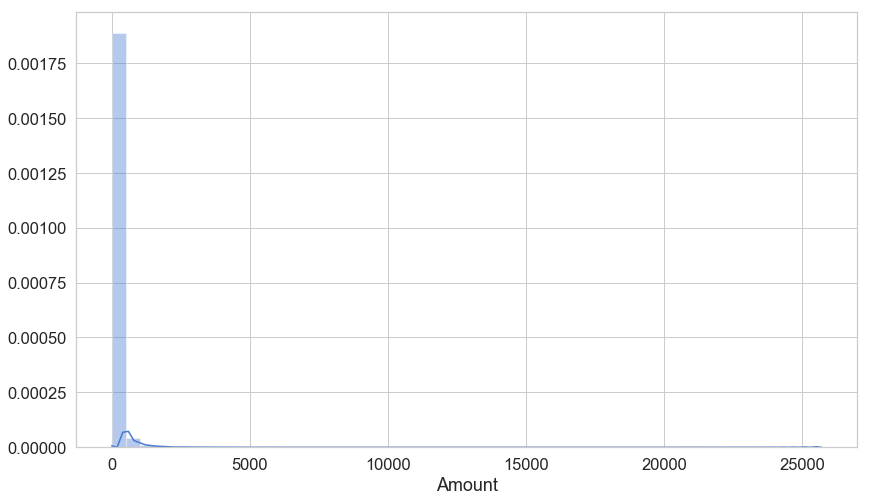

In [12]:
sns.distplot(dataset['Amount'])

From the above histogram plot, we notice that the amount variable is not normally distributed. The asymmetric tail extends towards the negative value than the positive value. This suggests evidence of anomaly that will be revealed with an appropriate graph.

In [ ]:

#Impact of the age on the output variables 
g = sns.boxplot(x=dataset["Amount"])

plt.suptitle('Amount')



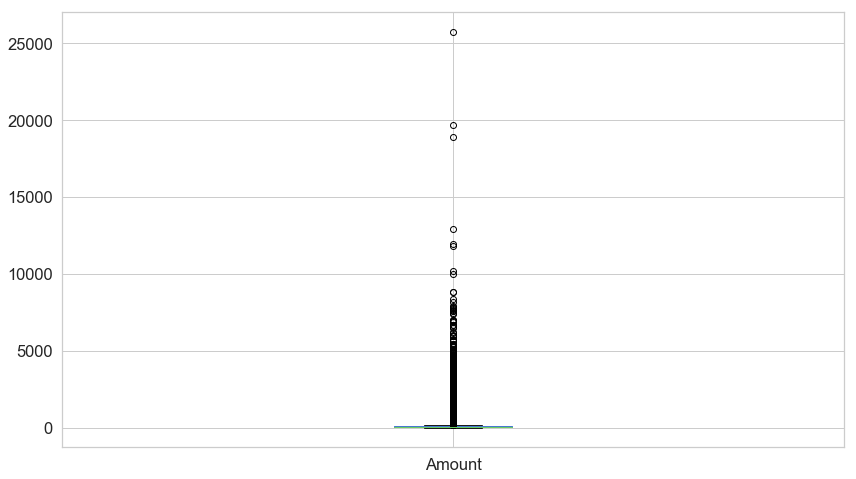

In [9]:
dataset['Amount'].plot(kind='box')
plt.show()

The above boxplot graph reveals a few selected fraud transaction cases that spend above the average customer limit. From the graph, we noticed that each customer spend an average of 7000 per specific period. The customer spend above 7000 may be classify as fraud. 

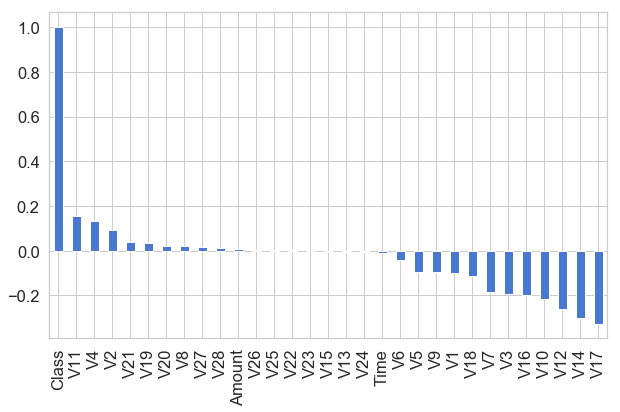

In [7]:

# I plot the correlation to examine the relationship between the dependent variable and explanatory variables 
plt.figure(figsize=(10,6))
dataset.corr()['Class'].sort_values(ascending=False).plot.bar()

In [8]:
# we drop the list of the all the relevant variables from the dataset
data = dataset.drop(['V26', 'V25','V22','V23', 'V15', 'V13', 'V24','Time'], axis=1)

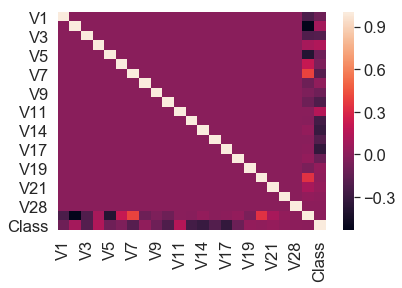

In [10]:

sns.heatmap(data.corr())

# Training and test for Autoencoder model

In [9]:

X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

# Building Autoencoder

In [10]:

input_dim = X_train.shape[1]
encoding_dim = 14

In [11]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

W0711 01:15:23.335504 15528 deprecation_wrapper.py:118] From C:\Users\Ajay\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [12]:
# 100 epochs with a batch size of 32 sampl
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

W0711 01:15:32.526577 15528 deprecation_wrapper.py:118] From C:\Users\Ajay\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 227454 samples, validate on 56962 samples


W0711 01:15:45.412085 15528 deprecation_wrapper.py:118] From C:\Users\Ajay\Anaconda3\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/100
227454/227454 [==============================] - 12s 54us/step - loss: 2967.7466 - acc: 0.8749 - val_loss: 3053.6936 - val_acc: 0.9096
Epoch 2/100
227454/227454 [==============================] - 10s 43us/step - loss: 2702.5253 - acc: 0.9165 - val_loss: 2830.5353 - val_acc: 0.9133
Epoch 3/100
227454/227454 [==============================] - 10s 46us/step - loss: 2502.3154 - acc: 0.9173 - val_loss: 2656.8397 - val_acc: 0.9265
Epoch 4/100
227454/227454 [==============================] - 10s 45us/step - loss: 2338.8674 - acc: 0.9167 - val_loss: 2512.4996 - val_acc: 0.9168
Epoch 5/100
227454/227454 [==============================] - 11s 47us/step - loss: 2205.1250 - acc: 0.9165 - val_loss: 2392.7487 - val_acc: 0.9253
Epoch 6/100
227454/227454 [==============================] - 10s 46us/step - loss: 2090.5047 - acc: 0.9153 - val_loss: 2288.5196 - val_acc: 0.9212
Epoch 7/100
227454/227454 [==============================] - 11s 46us/step - loss: 1989.4315 - acc: 0.9189 - val_loss:

In [13]:

autoencoder = load_model('model.h5')

# Evaluation


In [ ]:
rcParams['figure.figsize'] = 14, 8

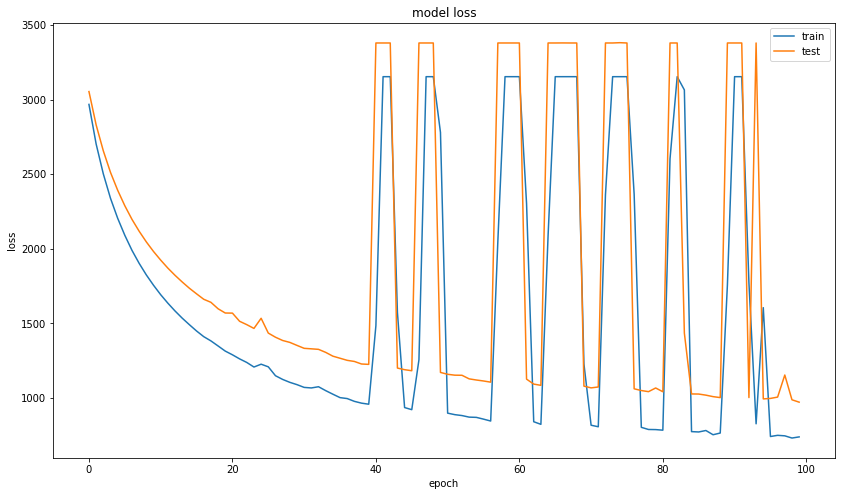

In [15]:
rcParams['figure.figsize'] = 14, 8
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The visual inspection of the reconstruction error for training and testing data suggests that our model adequately capture all the fraud cases in the dataset and tend to converge nicely.

In [16]:

predictions = autoencoder.predict(X_test)

In [17]:

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [18]:

error_df.describe()

,reconstruction_error,true_class
count,5.696200e+04,56962.000000
mean,9.724472e+02,0.001773
std,1.138472e+05,0.042071
min,1.528836e-01,0.000000
25%,1.012170e+00,0.000000
50%,2.296515e+00,0.000000
75%,9.560912e+00,0.000000
max,2.667472e+07,1.000000


# Reconstruction error without fraud


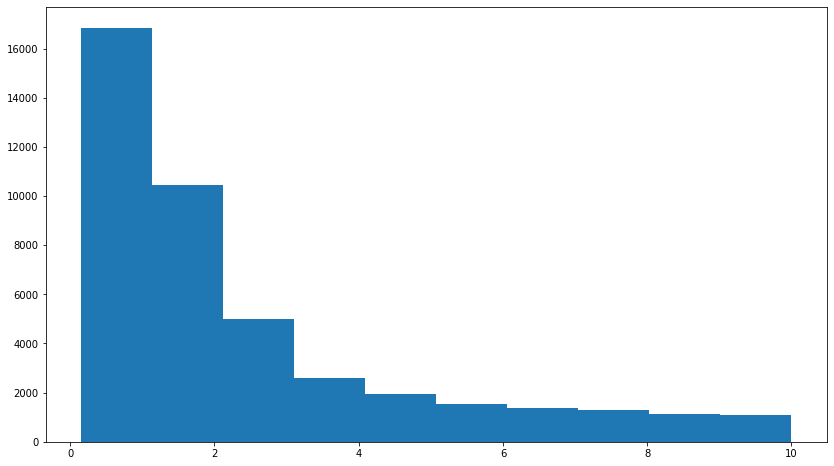

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

# Reconstruction error with fraud

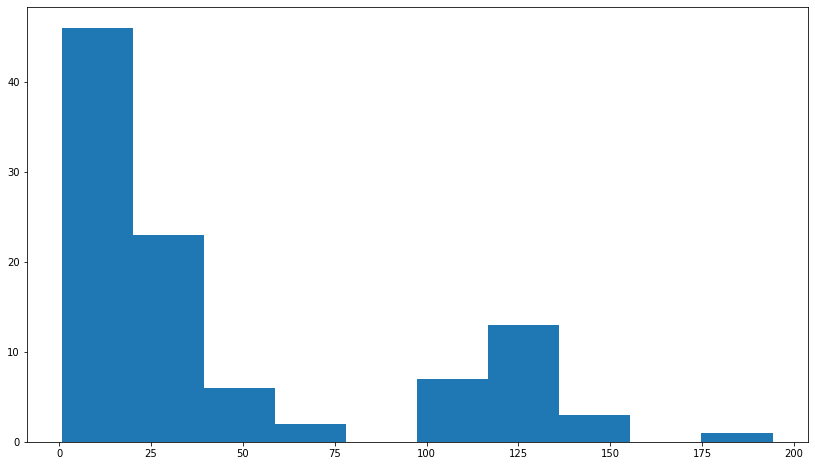

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

In [21]:

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

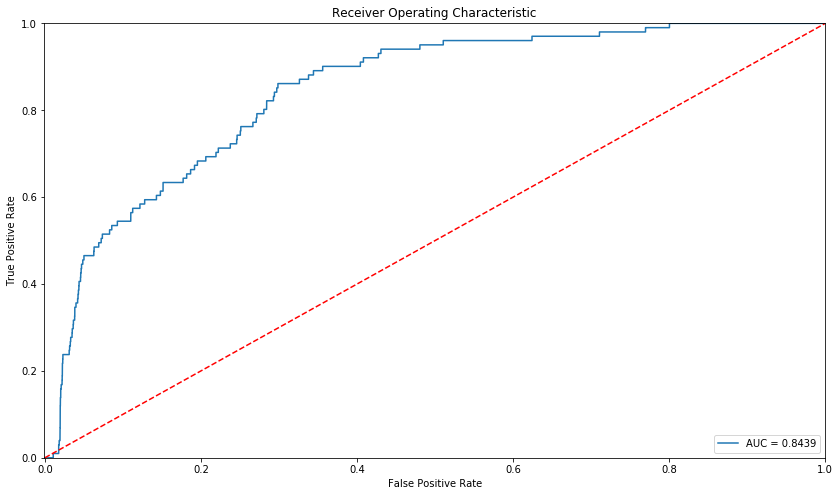

In [22]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

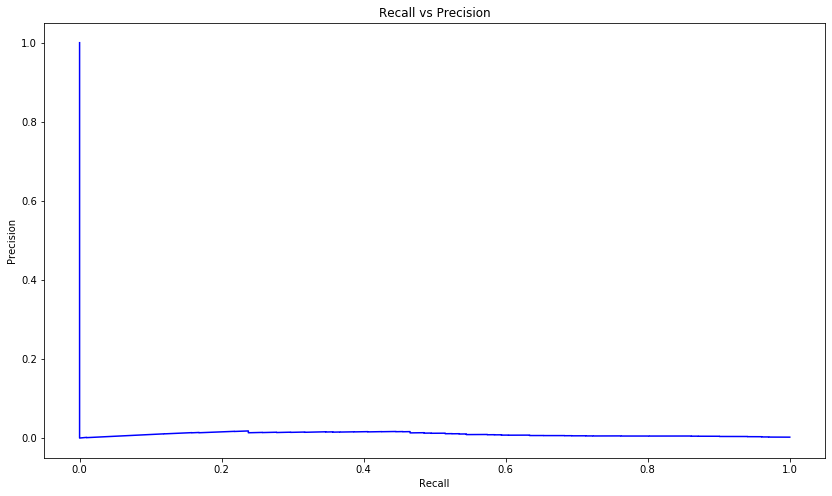

In [23]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

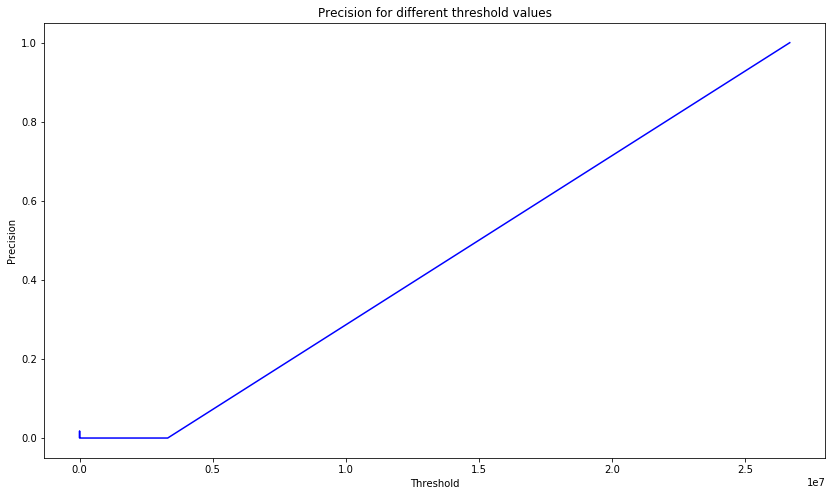

In [24]:

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

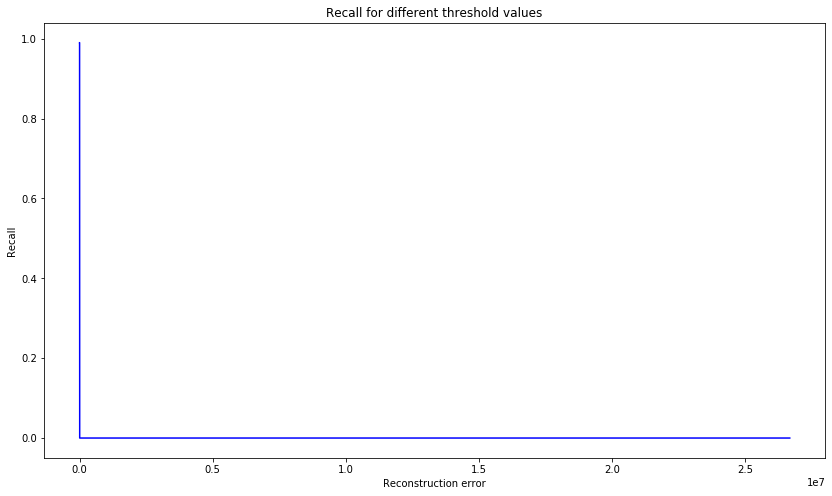

In [25]:

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [26]:

threshold = 2.9

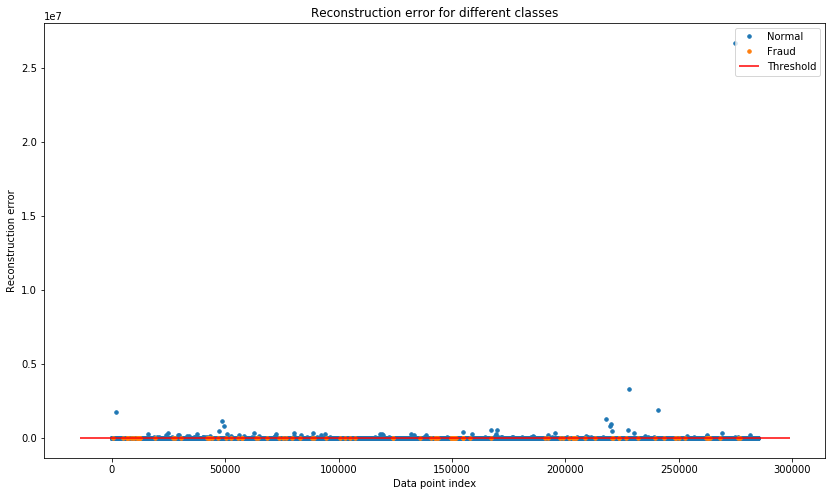

In [27]:

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

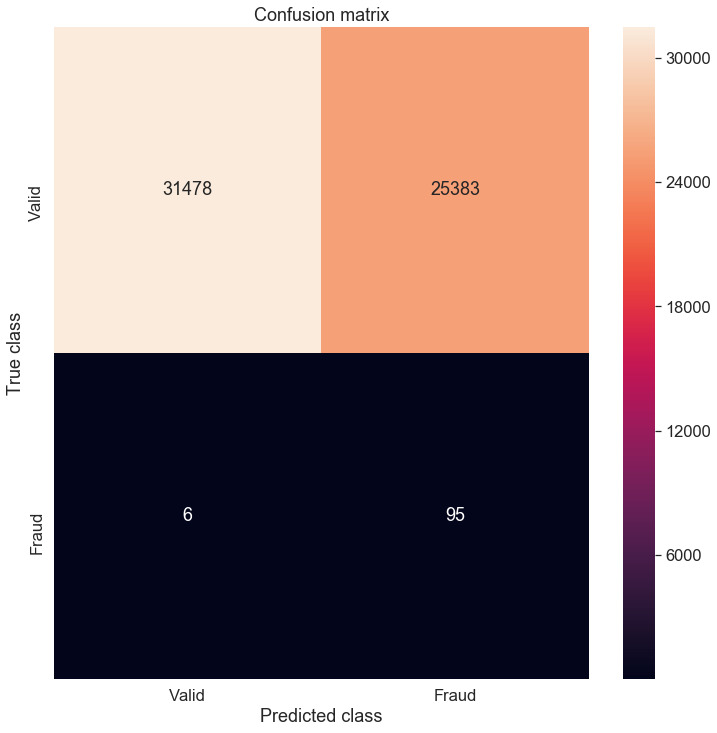

In [30]:

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [43]:
# we increase the number of thresholds to reduce the number of the likely false positive 
threshold = 7

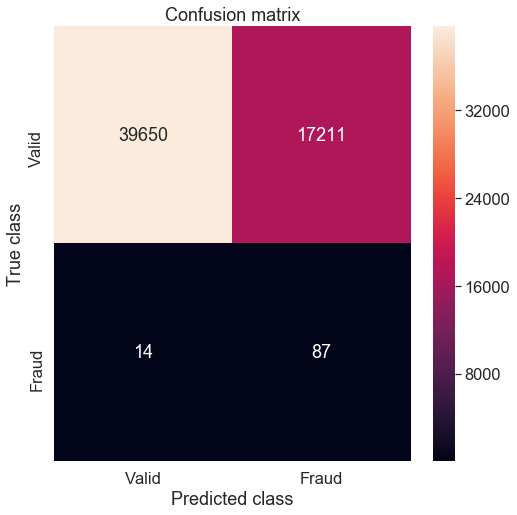

In [44]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

References 
https://blog.keras.io/building-autoencoders-in-keras.html
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb 
